# analysis of extended layer II dataset
This notebook will reproduce main figure 4 and related text/supplement. The core concepts for the classifer are described by Tang et al., 2014. To test the classifier, we can expand the dataset to include non-transgenic animals because the only thing that is required is confirmed histology in layer II. That is why the dataset is considerably larger than the dataset in figure 3 (other notebook). There are also some cells in the figure 3 dataset that were thrown out because the waveforms were not sufficiently similar in the laser and baseline session which are included here because that between trial instability (likely caused by plugging in the fiber) does not influence the baseline session analysis.  

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook
import nose as nose

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()


import pycircstat as pycircstat
import scipy as scipy
from scipy.stats import mannwhitneyu



## check which variables are in the dataframe 
this will give an overview of the variables in the dataframe. 

In [2]:
dataPile2 = pd.read_pickle("combined.pkl")
dataPile2.columns

Index(['cluster_no', 'tetrode_no', 'session_name', 'session_ts', 'animal_id',
       'n_drive_user', 'bins_angle_center_phase', 'hist_angle_smooth_phase',
       'phase_stats_mvl', 'phase_stats_mean', 'phase_stats_var',
       'informationcontent_bnt', 'tc_stats_hd_peakrate_bnt',
       'tc_stats_mean_direction_bnt', 'peak_rate_bnt', 'gridstats_spacing_bnt',
       'borderscore_bnt', 'informationrate_bnt', 'speedscore_bnt',
       'tc_stats_peakdirection_bnt', 'tc_stats_mvl_bnt', 'coherence_bnt',
       'grid_score_bnt', 'sparsity_bnt', 'theta_strength_bnt',
       'selectivity_bnt', 'mean_rate_bnt', 'theta_mean_phase_bnt',
       'hist_angle_smooth_bnt', 'bins_angle_center_bnt', 'calbindin_bnt',
       'angular_stability_bnt', 'calbindin_dist_bnt', 'burst_idx2',
       'burst_idx1'],
      dtype='object')

## A little cleanup of the dataframe 

In [3]:
#two quality control steps here. The first gets rid of a small number of cells with missing values. The second is mostly a sanity check that we have not included duplicate cells.

dataPile2= dataPile2.dropna(subset=['calbindin_bnt'])#quality control step to remove cells with nans. A few cells in the .pkl file will fall out here. 


drop_subgroup= ['session_ts','session_name','cluster_no','tetrode_no']
dataPile2 = dataPile2.drop_duplicates(subset=drop_subgroup, keep='first', inplace=False)

#Note that the step above is not needed for this particular .pkl file because the duplicates have already been removed, but it is an extremely useful quality control and sanity check when working with 
#a large dataset like this. Also, if you reload the pkl without restarting the kernel, it is possible that you will accidentally double the dataset and this line of code will become helpful. 
#The logic of the above line of code is that it will drop cells that have identical values for session name, cluster number, tetrode number and session_ts (precise date and time of the session). The combination of these things provides a 
#unique ID for a given cell, so if appears twice, we know something is wrong and to remove all but the first instance. If you want to prove to yourself that the code snippet works, you could eliminate all but
#'tetrode_no' and check the length. The length should be 4 because it takes the first instance of each tetrode and drops all other cells. Since we have 4 tetrodes, the resulting dataset should be length 4.

print(len(dataPile2))


1332


In [4]:
from numpy import nan

dataPile2.fillna(value=nan, inplace=True)


In [5]:
#We record multiple lfps per session and some scores for each lfp. This section picks just one of those for the plotting (hence the name '..._single') 
new_column = []
dataPile2.theta_mean_phase_bnt[dataPile2.theta_mean_phase_bnt=='']='nan'

for i in range(len(dataPile2)):
    mj = dataPile2.theta_mean_phase_bnt.iloc[i]
    if np.isscalar(mj)== True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
dataPile2['theta_mean_phase_bnt_single'] = new_column

new_column = []
for i in range(len(dataPile2)):
    mj = dataPile2.theta_strength_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
dataPile2['theta_strength_bnt_single'] = new_column

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pandas\core\ops.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Make separate dataframes for the two putative cell types plus another for cells that fall into the guard zone  
The following sections rely heavily on the classifier developed by Tang et al. The core idea is that pyramidal and stellate cells differ in their theta phase preference and can be separated on the basis of their prefered theta phase and depth of theta modulation. Correspondingly, their analysis showed that grid cells and border cells also clustered the same plots. Here we examine this classifier on our dataset. 
https://www.sciencedirect.com/science/article/pii/S0896627314010095?via%3Dihub

In [6]:

calbindin = dataPile2[(dataPile2.calbindin_bnt == 1)&(np.fabs(dataPile2.calbindin_dist_bnt)>=0.1)]#calbindin_dist_bnt is the distance to the decision boundary
stellate = dataPile2[(dataPile2.calbindin_bnt == 0)&(np.fabs(dataPile2.calbindin_dist_bnt)>=0.1)]
rest =dataPile2[np.fabs(dataPile2.calbindin_dist_bnt)<0.1]#this takes all of the cells that are within 0.1 of the boundary and places them in the guard zone. These cells are considered to be 
#too close to the decision boundary to be classified. You can change the value to make a wider guard zone if you want. We experimented with a few but nothing changed (see also the alternate clustering below) 

## Now start looking at the data 

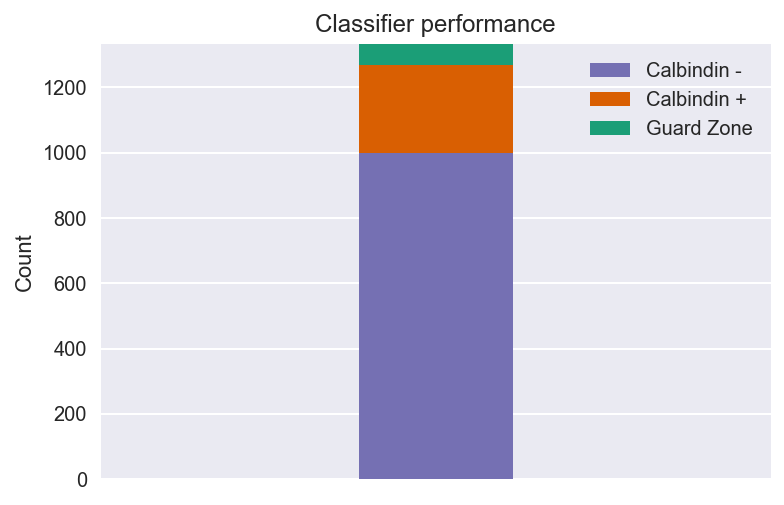

270
999
63


In [7]:
#make a stacked bar chart for the cells in each cell category
cb = len(calbindin)
st = len(stellate)
r = len(rest)
width = 0.23
ind = 1
p1 = plt.bar(ind, st, width, color='#7570b3')
p2 = plt.bar(ind, cb, width, color='#d95f02', bottom=st)
p3 = plt.bar(ind, r,width,color='#1b9e77',bottom=[cb+st])

#plt.xticks(ind, ('Tagge', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_xaxis().set_ticks([])

plt.legend((p1[0], p2[0],p3[0]), ('Calbindin -', 'Calbindin +', 'Guard Zone'))
plt.ylim(0,len(dataPile2))
plt.xlim(0.5,1.5)
plt.title('Classifier performance')
plt.ylabel('Count')
sns.despine(left=True,bottom=True)
#plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_classifier', format='png', dpi=1000)
plt.show()
print(cb)
print(st)
print (len(rest))

## Plot the data around a circle, color coded by putative cell type
here is the result of the classifier

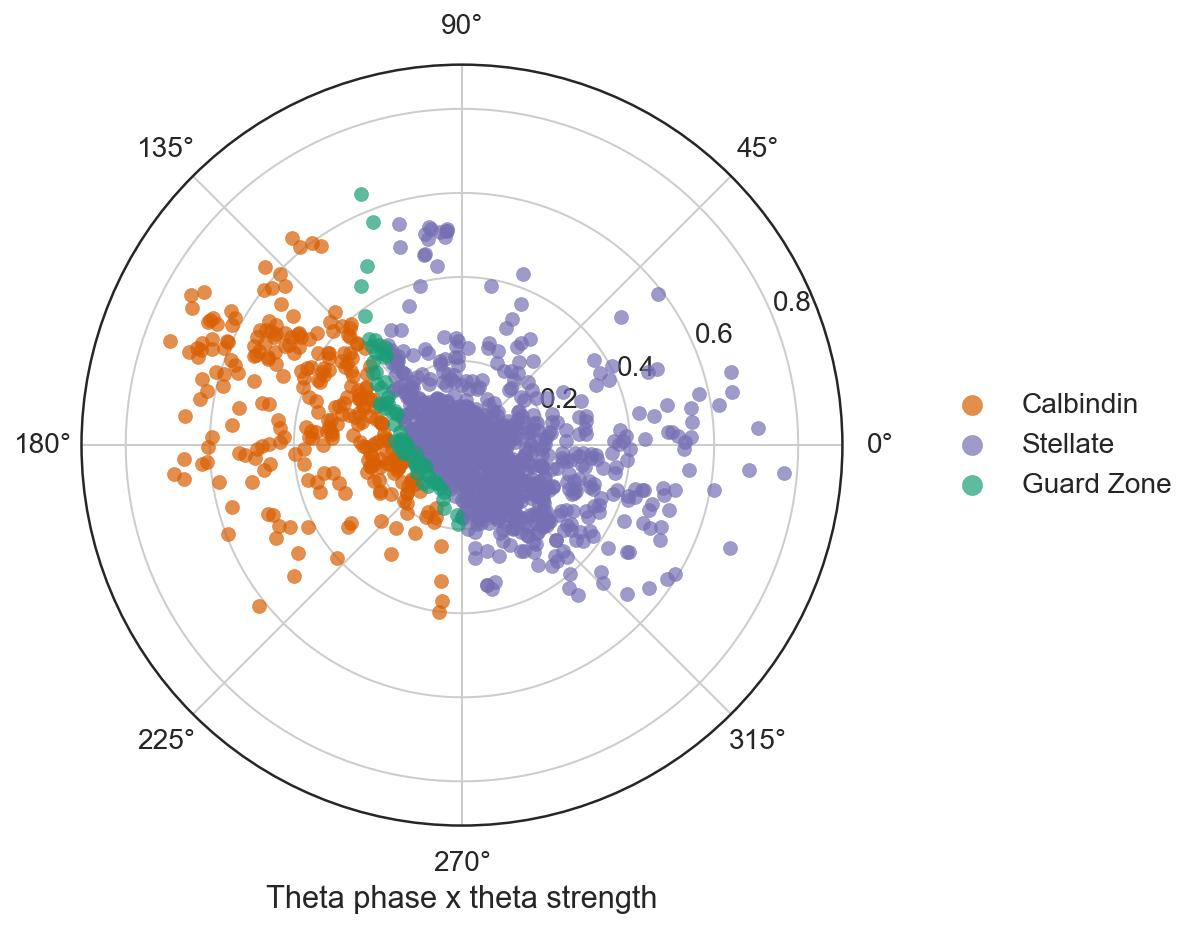

In [8]:
#This will make a plot of the datapoints around a cricle
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')#plot putative cb cells
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')#plot putative stellate cells 
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone')#plot cells in the guard zone 
ax.set_xlabel('Theta phase x theta strength')
#plt.title('Classification of Cells (n = 1393)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength all.svg', format='eps', dpi=1000, bbox_inches='tight')

plt.show()






### Same but for grid cells only. Make marker size proportional to grid score to visually check for trends in the data
This plot makes it clear that 1) grid cells show a very similar distribution as all other cells 2) cells with higher grid score do not cluster in one part of the plot and 3) many grid cells (including some of the ones with highest grid score) have very little theta modulation (close to the center)

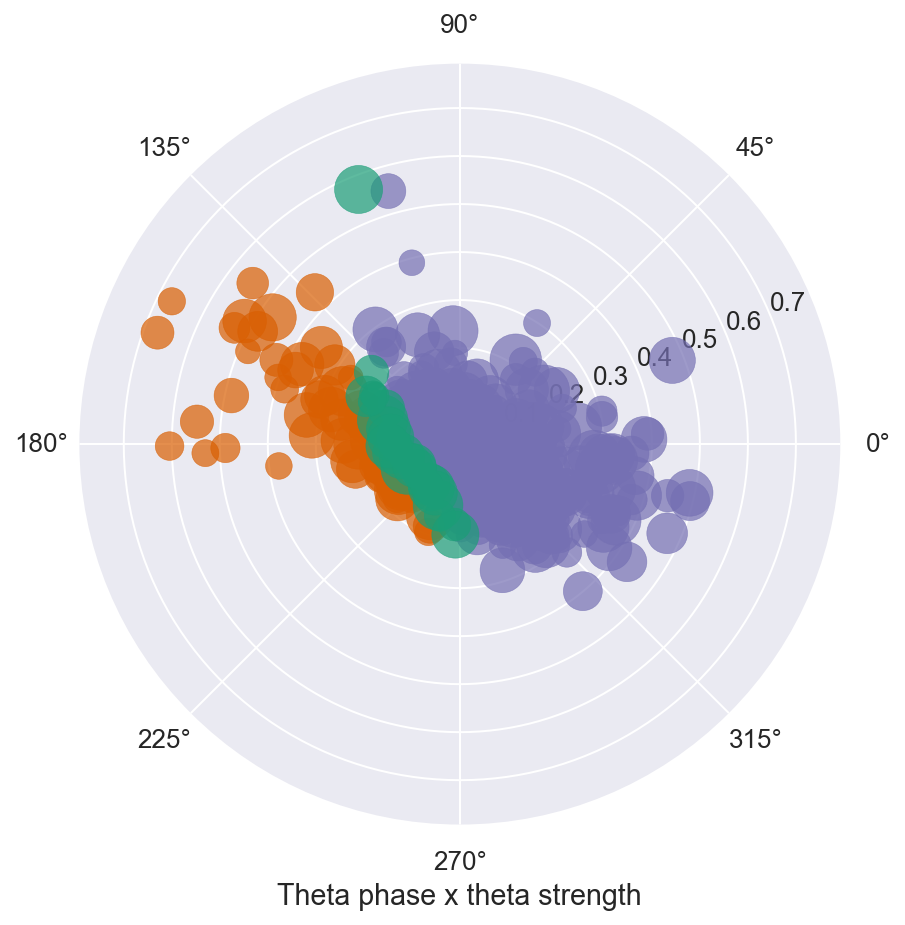

In [9]:
sns.set(font_scale=1.4,style='white')
sns.set(font_scale=1.3)
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
calbindinGC = calbindin[calbindin.grid_score_bnt > 0.2980]#plot grid cells in the putative cb group
stellateGC = stellate[stellate.grid_score_bnt > 0.2980]
restGC =rest[rest.grid_score_bnt > 0.2980]
ax.scatter(calbindinGC.theta_mean_phase_bnt_single.values.astype(float),calbindinGC.theta_strength_bnt_single.values.astype(float),c='#d95f02',s=(calbindinGC.grid_score_bnt*500).astype(int),alpha=.7,label='Calbindin') #plot grid cells in the putative cb group
ax.scatter(stellateGC.theta_mean_phase_bnt_single.values.astype(float),stellateGC.theta_strength_bnt_single.values.astype(float),c='#7570b3',s=(stellateGC.grid_score_bnt*500).astype(int),alpha=.7,label='Stellate') #plot grid cells in the putative stelalte group
ax.scatter(restGC.theta_mean_phase_bnt_single.values.astype(float),restGC.theta_strength_bnt_single.values.astype(float),c='#1b9e77',s=(restGC.grid_score_bnt*500).astype(int),alpha=.7,label='Unclassified')#plot grid cells in the guard zone
ax.set_xlabel('Theta phase x theta strength')
#plt.title('Grid Cells Only')




In [10]:
len(calbindinGC) +len(stellateGC) +len(restGC)#this gets the total number of grid cells in the whole population for reporting in the text and titles

411

### unwrap the plots to make them a bit easier to see

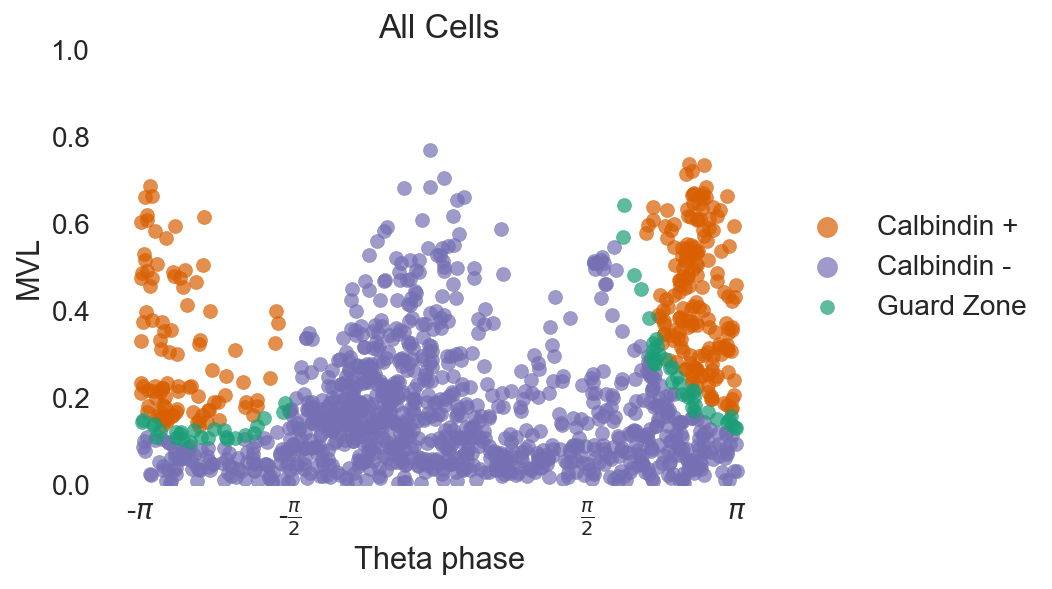

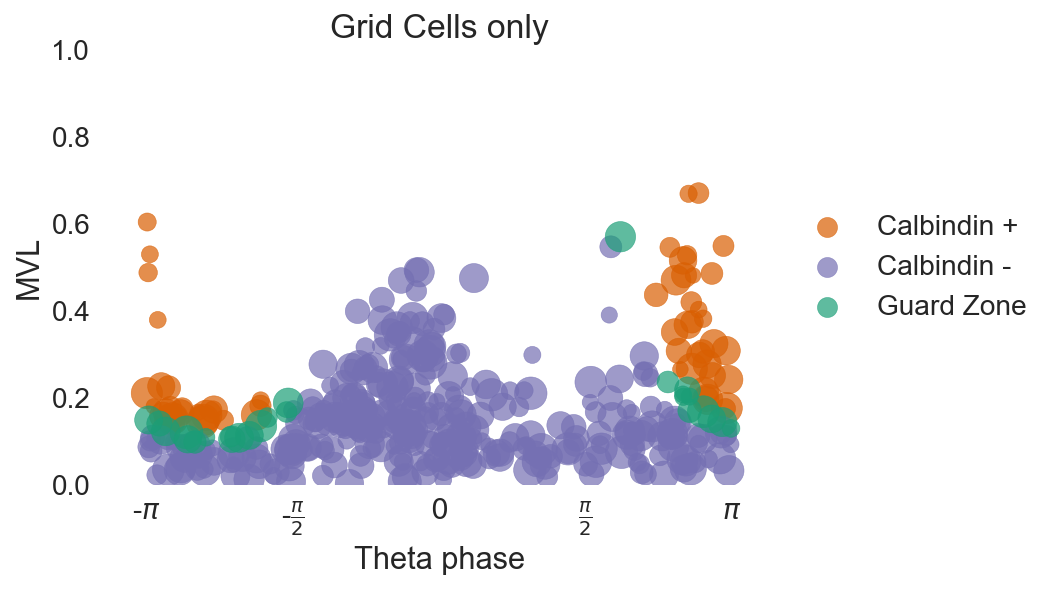

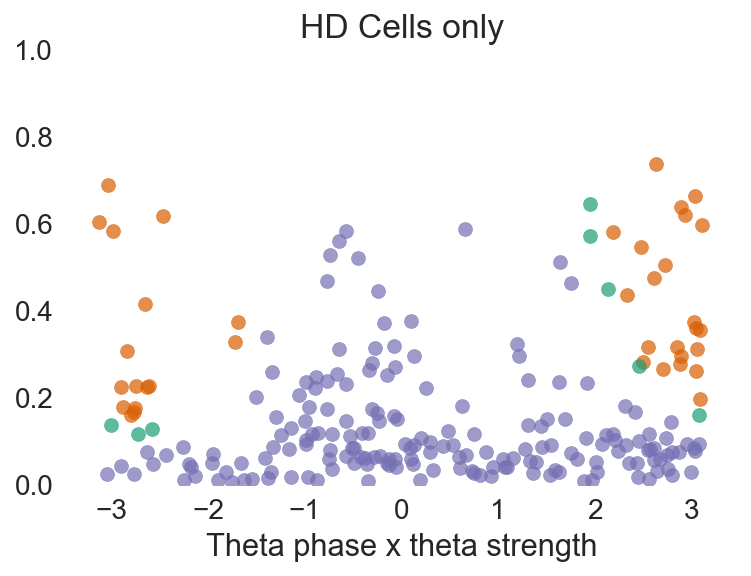

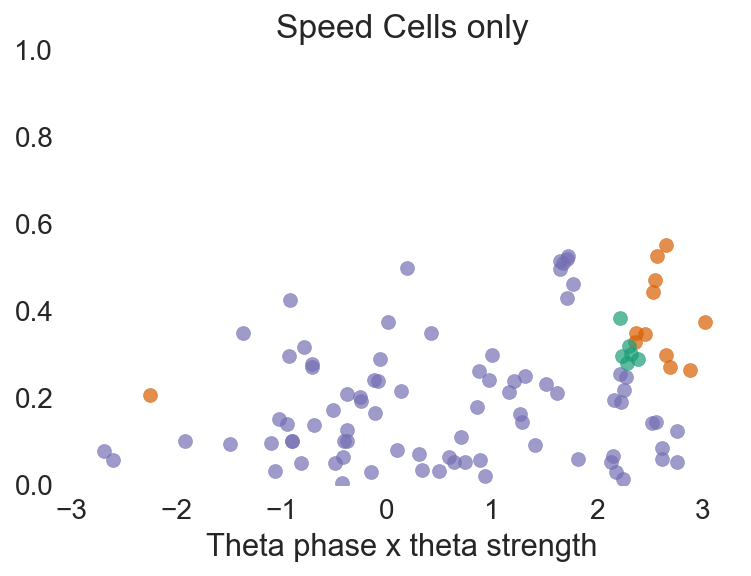

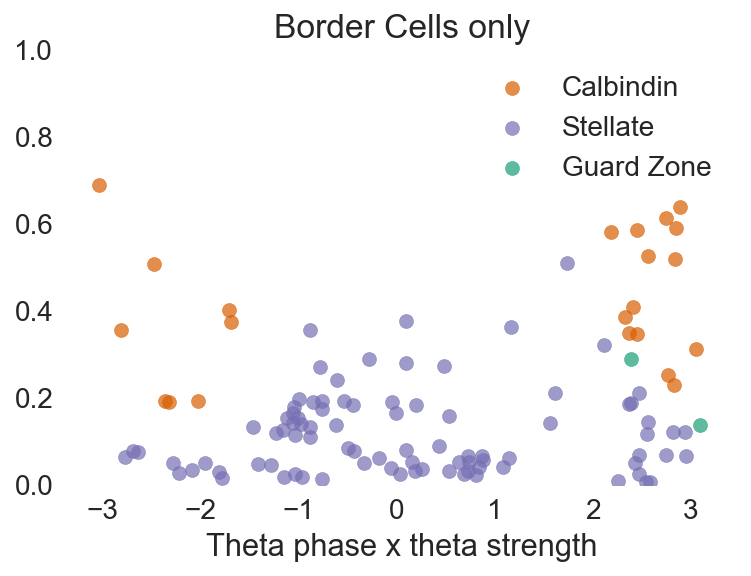

In [11]:
sns.set(font_scale=1.4,style='white')
#ax = figure.add_subplot(1,3,1)
plt.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase')
plt.ylabel('MVL')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
plt.ylim([0,1])
pi = np.pi
plt.xticks([-pi, -pi/2, 0, pi/2, pi],
           [r'-$\pi$',r'-$\frac{\pi}{2}$','$0$', r'$\frac{\pi}{2}$', r'$\pi$' ])
plt.title('All Cells')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\linear phase vs strength all.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()




#ax2 = figure.add_subplot(1,3,3)
plt.scatter(calbindinGC.theta_mean_phase_bnt_single.values.astype(float),calbindinGC.theta_strength_bnt_single.values.astype(float),s=(calbindinGC.grid_score_bnt*200).astype(int),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellateGC.theta_mean_phase_bnt_single.values.astype(float),stellateGC.theta_strength_bnt_single.values.astype(float),s=(stellateGC.grid_score_bnt*200).astype(int),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(restGC.theta_mean_phase_bnt_single.values.astype(float),restGC.theta_strength_bnt_single.values.astype(float),s=(restGC.grid_score_bnt*200).astype(int),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase')
plt.ylabel('MVL')
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.ylim([0,1])
plt.xticks([-pi, -pi/2, 0, pi/2, pi],
           [r'-$\pi$',r'-$\frac{\pi}{2}$','$0$', r'$\frac{\pi}{2}$', r'$\pi$' ])
plt.title('Grid Cells only')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\linear phase vs strength gcs.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

calbindinHD = calbindin[calbindin.tc_stats_mvl_bnt > 0.2253]
stellateHD = stellate[stellate.tc_stats_mvl_bnt > 0.2253]
restHD =rest[rest.tc_stats_mvl_bnt > 0.2253]

plt.scatter(calbindinHD.theta_mean_phase_bnt_single.values.astype(float),calbindinHD.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin +')
plt.scatter(stellateHD.theta_mean_phase_bnt_single.values.astype(float),stellateHD.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Calbindin -')
plt.scatter(restHD.theta_mean_phase_bnt_single.values.astype(float),restHD.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.ylim([0,1])
plt.title('HD Cells only')
plt.show()

calbindinSP = calbindin[calbindin.speedscore_bnt > 0.2525]
stellateSP = stellate[stellate.speedscore_bnt > 0.2525]
restSP =rest[rest.speedscore_bnt > 0.2525]

plt.scatter(calbindinSP.theta_mean_phase_bnt_single.values.astype(float),calbindinSP.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')
plt.scatter(stellateSP.theta_mean_phase_bnt_single.values.astype(float),stellateSP.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')
plt.scatter(restSP.theta_mean_phase_bnt_single.values.astype(float),restSP.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.ylim([0,1])
plt.title('Speed Cells only')
plt.show()

calbindinB = calbindin[calbindin.borderscore_bnt > 0.4957]
stellateB = stellate[stellate.borderscore_bnt > 0.4957]
restB =rest[rest.borderscore_bnt > 0.4957]

plt.scatter(calbindinB.theta_mean_phase_bnt_single.values.astype(float),calbindinB.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin')
plt.scatter(stellateB.theta_mean_phase_bnt_single.values.astype(float),stellateB.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate')
plt.scatter(restB.theta_mean_phase_bnt_single.values.astype(float),restB.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label = 'Guard Zone')
sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase x theta strength')
plt.legend()
plt.ylim([0,1])
plt.title('Border Cells only')
plt.show()



## Now do some comparisons between putative cell types

### grid score first 

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


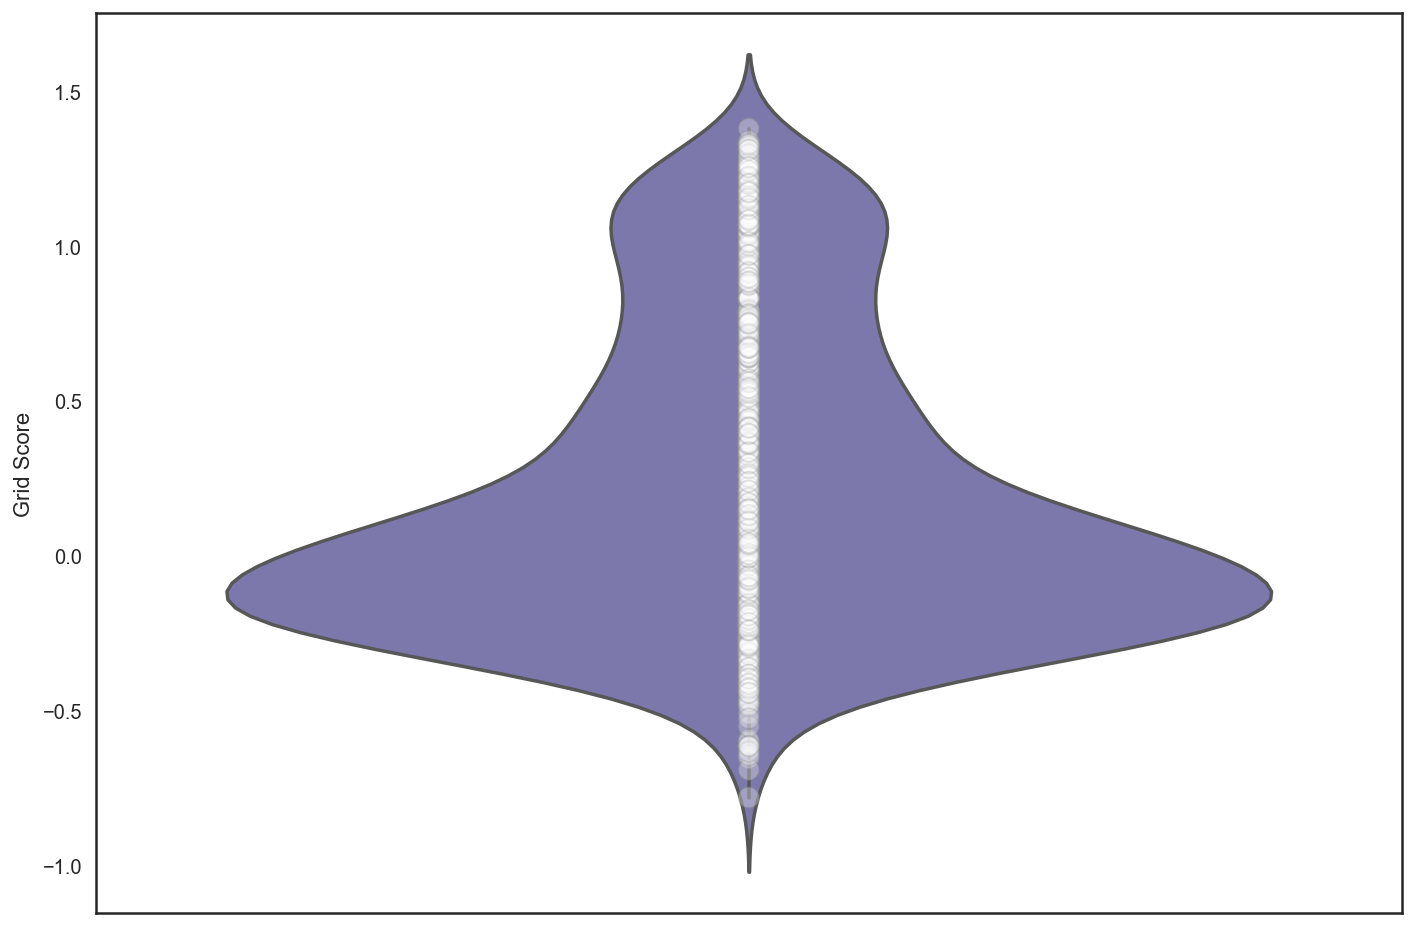

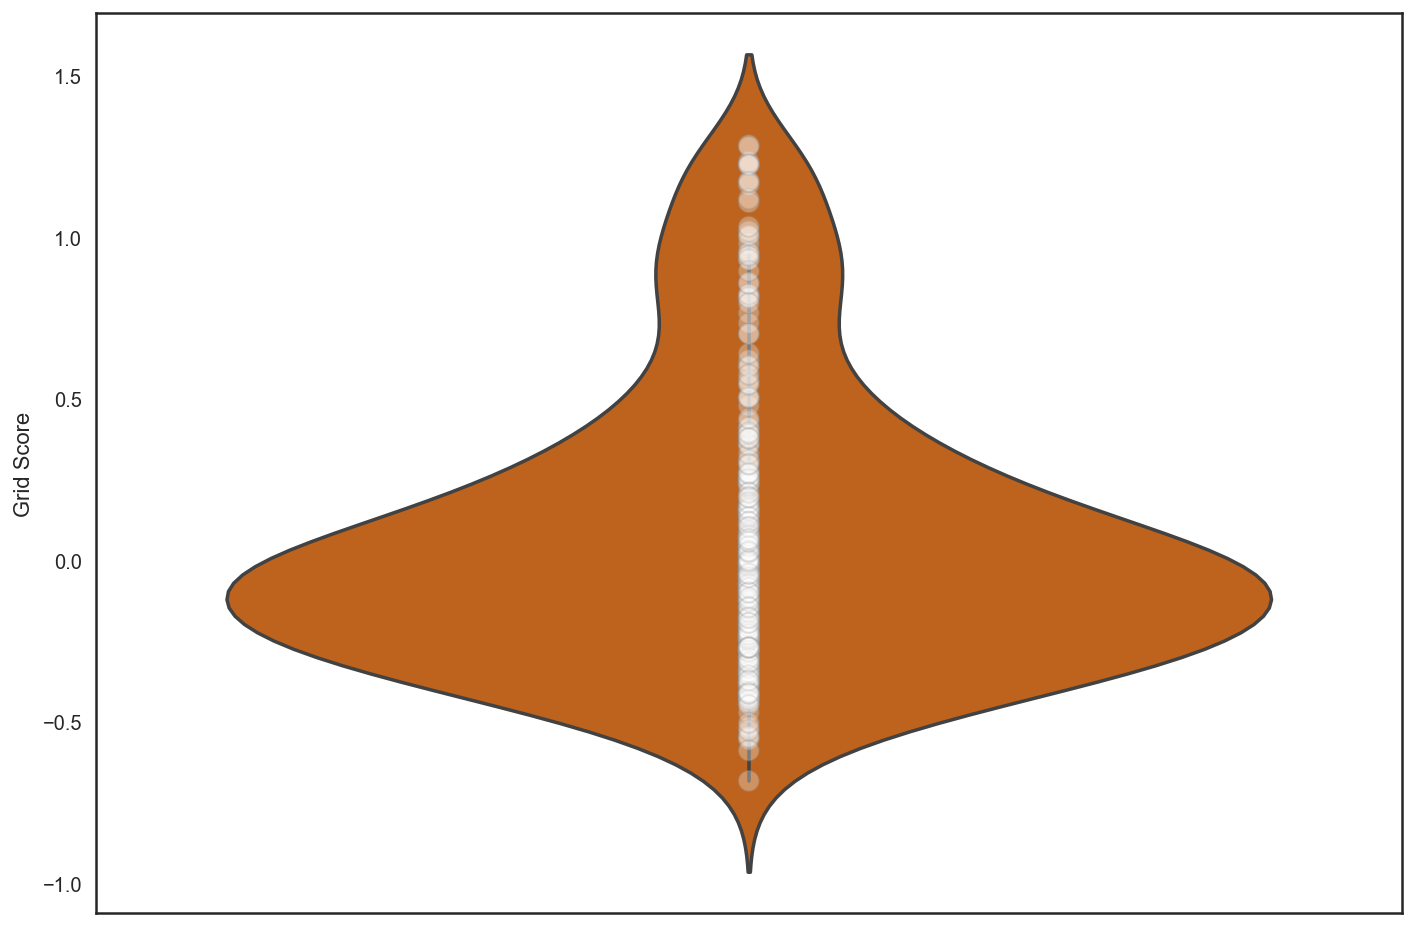

In [12]:


stellate["null"] = ""
figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

ax = sns.violinplot(x = stellate["null"],y=stellate.grid_score_bnt.astype(float) , color='#7570b3',alpha = 0.1)

ax = sns.stripplot(x = stellate["null"],y=stellate.grid_score_bnt.astype(float) , dodge = True, color = 'white', size=10,linewidth=1,alpha = 0.3)
ax.set(xlabel='', ylabel='Grid Score')


calbindin["null"] = ""
figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

ax = sns.violinplot(x = calbindin["null"],y=calbindin.grid_score_bnt.astype(float) , color='#d95f02',alpha = 0.1)

ax = sns.stripplot(x = calbindin["null"],y=calbindin.grid_score_bnt.astype(float) , dodge = True, color = 'white', size=10,linewidth=1,alpha = 0.3)
ax.set(xlabel='', ylabel='Grid Score')


In [13]:
#compare grid scores for the two populations. Note that for grid score there can be some nans because the program cannot calculate a score for a small number of cells due to a failure to find fields. 
#these cells need to be dropped
ab = calbindin.grid_score_bnt
ab = ab.dropna()
new_list = [x+1 for x in ab]
ac = stellate.grid_score_bnt
ac = ac.dropna()
new_list2 = [x+1 for x in ac]
scipy.stats.mannwhitneyu(new_list, new_list2, alternative = 'two-sided')
#scipy.stats.mannwhitneyu(calbindin.grid_score_bnt, stellate.grid_score_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=114913.0, pvalue=0.00031585053539378606)

### now border score

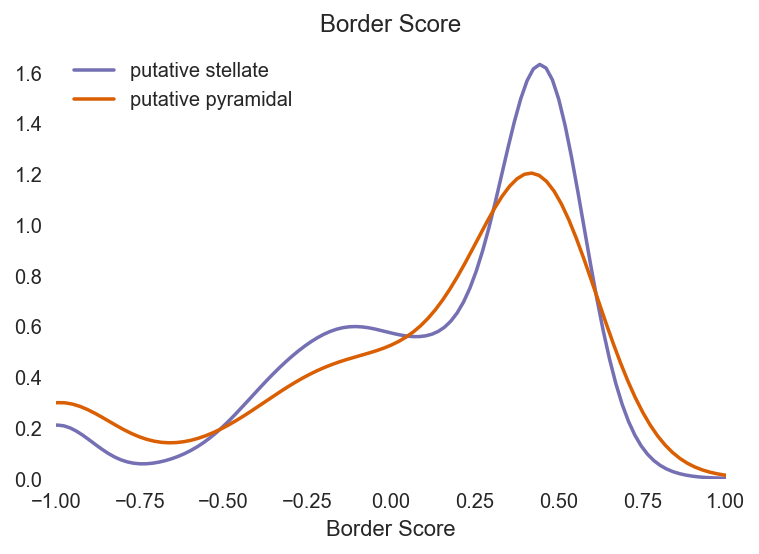

In [14]:
sns.kdeplot(stellate.borderscore_bnt, shade=False, color="#7570b3",label='putative stellate')
sns.kdeplot(calbindin.borderscore_bnt, shade=False, color="#d95f02",label='putative pyramidal')

sns.despine(left=True,bottom=True)
sns.set_style("white")
plt.xlabel('Border Score')
plt.title('Border Score')
plt.legend()
plt.xlim( (-1.0, 1) )
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [15]:
#compare border scores for the two populations
scipy.stats.mannwhitneyu(calbindin.borderscore_bnt, stellate.borderscore_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=127330.5, pvalue=0.15843099555010154)

### Speed score

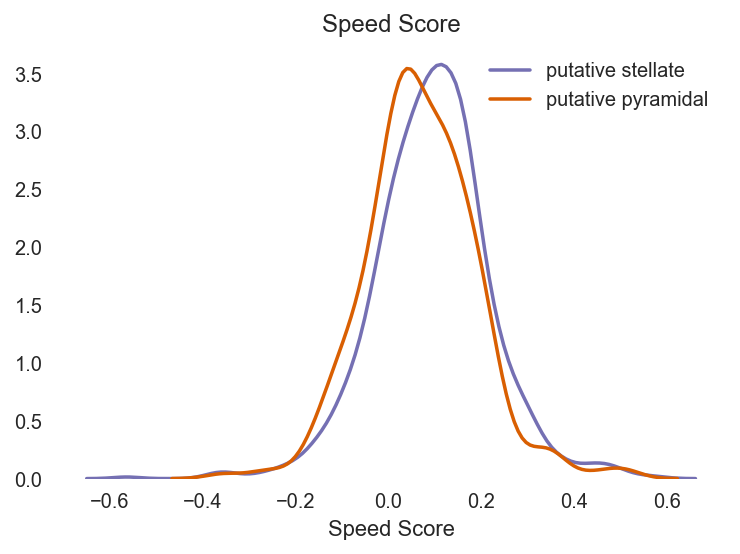

In [16]:
sns.kdeplot(stellate.speedscore_bnt, shade=False, color="#7570b3",label='putative stellate')
sns.kdeplot(calbindin.speedscore_bnt, shade=False, color="#d95f02",label='putative pyramidal')

sns.despine(left=True,bottom=True)
sns.set_style("white")
plt.xlabel('Speed Score')
plt.title('Speed Score')
plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_kde.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [17]:

scipy.stats.mannwhitneyu(calbindin.speedscore_bnt, stellate.speedscore_bnt, alternative = "two-sided")

MannwhitneyuResult(statistic=116452.0, pvalue=0.00056858922727443082)

## Now make stacked bar charts, putative stellate cells first

In [18]:
cells = stellate

In [19]:
# set some thresholds based on the 95% threshold of the shuffled distribution
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007 

In [20]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(~cells.index.isin(gridc.index)) &\
               (~cells.index.isin(hdc.index))  &\
               (~cells.index.isin(speedc.index))  &\
               (~cells.index.isin(borderc.index))]

In [21]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [22]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len


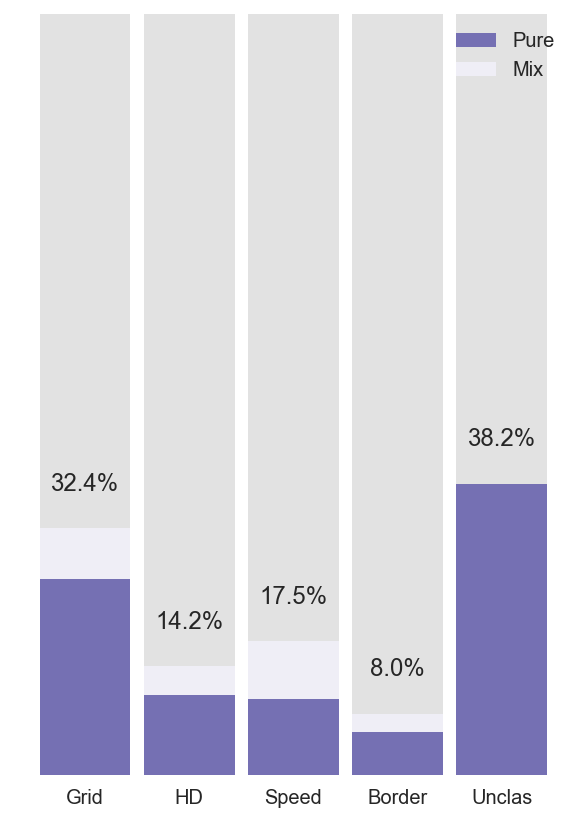

In [23]:
# grid, hd, speed, border, unclassified


seq_col_brew = sns.color_palette(sns.light_palette("#7570b3",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\putstellate_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

### make stacked bars for the putative pyramidal population 

In [24]:
cb_cells = calbindin

In [25]:
cb_gridc = cb_cells[cb_cells.grid_score_bnt > grid_cutoff]
cb_hdc = cb_cells[(cb_cells.tc_stats_mvl_bnt > mvl_cutoff)&(cb_cells.angular_stability_bnt>0.6)]
cb_speedc = cb_cells[cb_cells.speedscore_bnt > speed_cutoff]
cb_borderc = cb_cells[cb_cells.borderscore_bnt > border_cutoff]


cb_unclas = cb_cells[(~cb_cells.index.isin(cb_gridc.index)) &\
               (~cb_cells.index.isin(cb_hdc.index))  &\
               (~cb_cells.index.isin(cb_speedc.index))  &\
               (~cb_cells.index.isin(cb_borderc.index))]

In [26]:
cb_pure_gridc = cb_gridc[(~cb_gridc.index.isin(cb_hdc.index)) & (~cb_gridc.index.isin(cb_speedc.index)) & (~cb_gridc.index.isin(cb_borderc.index))]
cb_pure_hdc = cb_hdc[(~cb_hdc.index.isin(gridc.index)) & (~cb_hdc.index.isin(cb_speedc.index)) & (~cb_hdc.index.isin(borderc.index))]
cb_pure_borderc = cb_borderc[(~cb_borderc.index.isin(cb_gridc.index)) & (~cb_borderc.index.isin(cb_speedc.index)) & (~cb_borderc.index.isin(cb_hdc.index))]
cb_pure_speedc = cb_speedc[(~cb_speedc.index.isin(gridc.index)) & (~cb_speedc.index.isin(cb_borderc.index)) & (~cb_speedc.index.isin(cb_hdc.index))]

In [27]:
cb_len = len(cb_cells)
# Grid
cb_grid_len = len(cb_gridc)
cb_frac_grid = cb_grid_len/cb_len
cb_pure_grid_len = len(cb_pure_gridc)
cb_mix_grid_len = cb_grid_len-cb_pure_grid_len

# HD
cb_hd_len = len(cb_hdc)
cb_frac_hd = cb_hd_len/cb_len
cb_pure_hd_len = len(cb_pure_hdc)
cb_mix_hd_len = cb_hd_len-cb_pure_hd_len

# Speed
cb_speed_len = len(cb_speedc)
cb_frac_speed = cb_speed_len/cb_len
cb_pure_speed_len = len(cb_pure_speedc)
cb_mix_speed_len = cb_speed_len-cb_pure_speed_len

# Border
cb_border_len = len(cb_borderc)
cb_frac_border = cb_border_len/cb_len
cb_pure_border_len = len(cb_pure_borderc)
cb_mix_border_len = cb_border_len-cb_pure_border_len

# Rest
#unstable_HD = cb_cells[(cb_cells.tc_stats_mvl_bnt > mvl_cutoff)&(cb_cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
cb_unclas_len = len(cb_unclas)
cb_frac_unclas = cb_unclas_len/cb_len


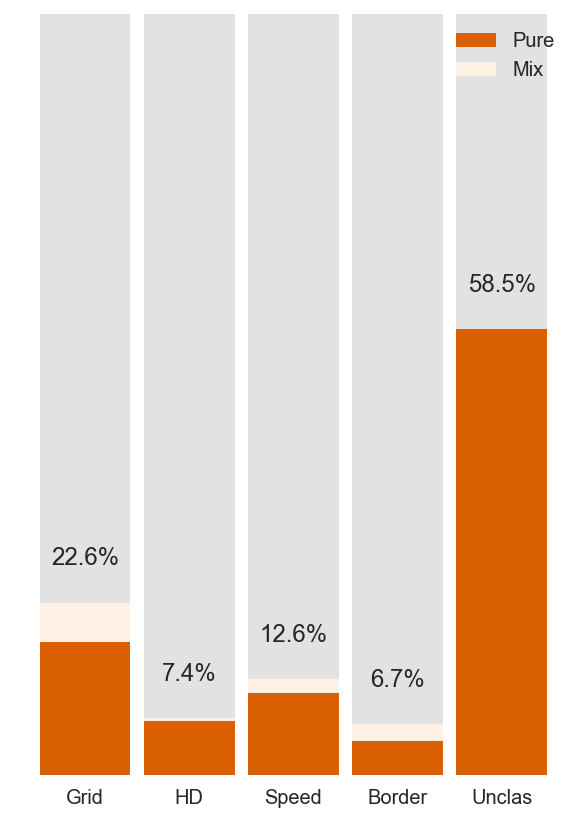

In [28]:
# grid, hd, speed, border, unclassified


seq_col_brew = sns.color_palette(sns.light_palette("#d95f02",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (cb_pure_grid_len/cb_len, cb_pure_hd_len/cb_len, cb_pure_speed_len/cb_len, cb_pure_border_len/cb_len, cb_unclas_len/cb_len)
mix = (cb_mix_grid_len/cb_len, cb_mix_hd_len/cb_len, cb_mix_speed_len/cb_len, cb_mix_border_len/cb_len,0)

rest = ((cb_len-(cb_pure_grid_len+cb_mix_grid_len))/cb_len,\
        (cb_len-(cb_pure_hd_len+cb_mix_hd_len))/cb_len,\
        (cb_len-(cb_pure_speed_len+cb_mix_speed_len))/cb_len,\
        (cb_len-(cb_pure_border_len+cb_mix_border_len))/cb_len,\
        (cb_len-cb_unclas_len)/cb_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [cb_frac_grid,cb_frac_hd,cb_frac_speed,cb_frac_border,cb_frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\putcalbindin_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

### Now look at the cells that fall in the guard zone...why not?

In [29]:
rest =dataPile2[np.fabs(dataPile2.calbindin_dist_bnt)<0.1]
cells = rest

In [30]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]


unclas = cells[(~cells.index.isin(gridc.index)) &\
               (~cells.index.isin(hdc.index))  &\
               (~cells.index.isin(speedc.index))  &\
               (~cells.index.isin(borderc.index))]

In [31]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [32]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len


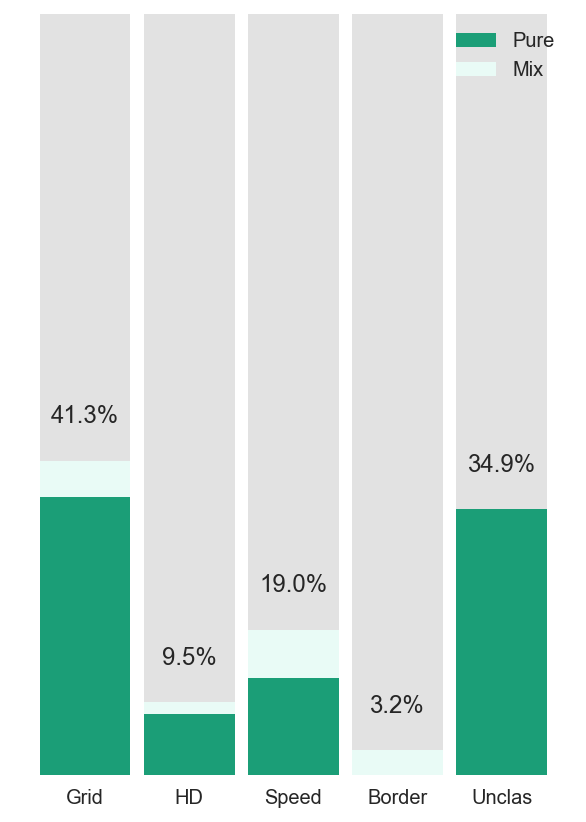

In [33]:
# grid, hd, speed, border, unclassified


seq_col_brew = sns.color_palette(sns.light_palette("#1b9e77",5))
sns.set_palette(seq_col_brew)
#sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
#plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\guardzone_stacked_bar.svg', format='svg', dpi=1000)
plt.show()

## Ignore putative cell type and just look at the theta modulation of different functional cell types 

In [34]:
cells = dataPile2
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(cells.grid_score_bnt <= grid_cutoff) &\
               (cells.tc_stats_mvl_bnt <= mvl_cutoff) &\
               (cells.speedscore_bnt <= speed_cutoff) &\
               (cells.borderscore_bnt <= border_cutoff)]

In [35]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

print(len(pure_gridc))
print(len(pure_hdc))
print(len(pure_speedc))
print(len(pure_borderc))

327
121
127
68


In [36]:
ab = []
ab= pd.concat([gridc['phase_stats_mvl'], hdc['phase_stats_mvl'],speedc['phase_stats_mvl'],borderc['phase_stats_mvl']], axis=1)
ab.columns = ['grid', 'HD','Speed', 'Border']

### create a separate dataframe for making violin plots

In [37]:
test = []
new_column = []

for i in range(len(pure_gridc)):
    new_column.append(1)

# now overwrite previous column:


for i in range(len(pure_borderc)):
    new_column.append(3)

# now overwrite previous column:

for i in range(len(pure_speedc)):
    new_column.append(2)

# now overwrite previous column:

for i in range(len(pure_hdc)):
    new_column.append(4)
test = new_column

test2 = []
new_column2 = []

for i in range(len(pure_gridc)):
    new_column2.append(gridc.iloc[i].phase_stats_mvl)
# now overwrite previous column:


for i in range(len(pure_borderc)):
    new_column2.append(borderc.iloc[i].phase_stats_mvl)

# now overwrite previous column:

for i in range(len(pure_speedc)):
    new_column2.append(speedc.iloc[i].phase_stats_mvl)

# now overwrite previous column:

for i in range(len(pure_hdc)):
    new_column2.append(hdc.iloc[i].phase_stats_mvl)

test2 = new_column2
# now overwrite previous column:
ts1 = np.array(test)
ts2 = np.array(test2)
ts1=np.reshape(ts1,(len(ts1),1))
ts2=np.reshape(ts2,(len(ts2),1))
fk = np.hstack((ts1,ts2))

fku = pd.DataFrame(fk)
fku.columns = ['functional','mvl']

### Make a violin plot of theta modulation by type. 
Note that the violin and associated stats are for "pure" cells only to avoid double dipping

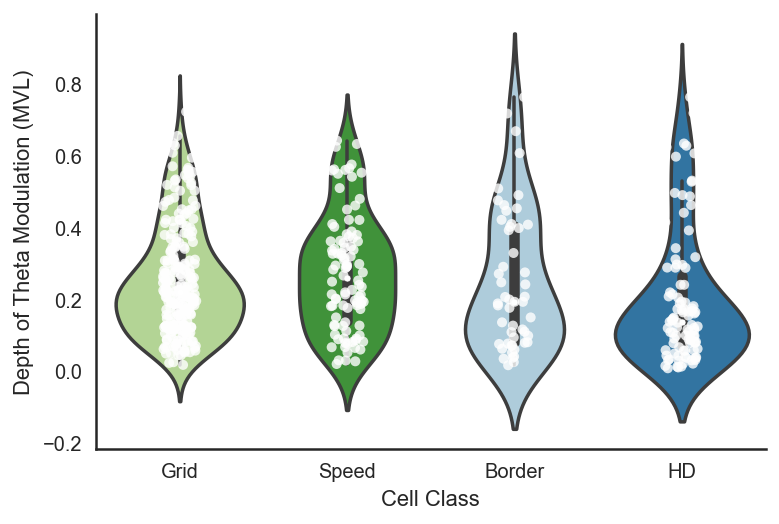

In [38]:
newp =  sns.color_palette(['#b2df8a','#33a02c','#a6cee3','#1f78b4'])
ind = np.arange(4) 
ax = sns.violinplot(x="functional", y="mvl", data=fku, palette=newp,split = True)
ax = sns.stripplot(x="functional", y="mvl", data=fku,color='white', jitter = True, alpha = 0.8)
plt.xlabel('Cell Class')
plt.ylabel('Depth of Theta Modulation (MVL)')
plt.xticks(ind, ('Grid','Speed','Border', 'HD') )
sns.despine()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\theta mod by class.svg', format='svg', dpi=1000)
plt.show()

### now a bunch of statistics (related to figure 4E and main text)  

In [39]:
#Compare theta modulation of grid cells to non-grid cells 
gcs = dataPile2[dataPile2.grid_score_bnt> 0.2980]
nongcs = dataPile2[dataPile2.grid_score_bnt< 0.2980]
scipy.stats.mannwhitneyu(gcs.theta_strength_bnt_single, nongcs.theta_strength_bnt_single,alternative = "two-sided")


MannwhitneyuResult(statistic=162644.0, pvalue=9.2823990524573566e-05)

In [40]:
scipy.stats.mannwhitneyu(gridc.theta_strength_bnt_single, borderc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=22816.0, pvalue=0.08711833378111325)

In [41]:
#get the mean preferred theta pahse for all grid cells
math.degrees(pycircstat.mean(gcs.theta_mean_phase_bnt_single))

299.239718054434

In [42]:
#get the std of the preferred theta phase
math.degrees(pycircstat.std(gcs.theta_mean_phase_bnt_single))

120.12837763380428

In [43]:
#get mean of preferred theta phase for border cells
math.degrees(pycircstat.mean(borderc.theta_mean_phase_bnt_single))

312.05397929114486

In [44]:
#get std of preferred theta phase for border cells
math.degrees(pycircstat.std(borderc.theta_mean_phase_bnt_single))

128.85204561758766

In [45]:
#get  of preferred theta phase for border cells
np.mean(pure_hdc.theta_strength_bnt_single)

0.16126443846284927

### compare theta modulation of pure cell types against each other (related to figure 4F)

In [46]:
np.mean(pure_borderc.theta_strength_bnt_single,)

0.17730145297107522

In [47]:
np.mean(pure_gridc.theta_strength_bnt_single)

0.16886875886417649

In [48]:
np.mean(pure_speedc.theta_strength_bnt_single)

0.22633384383307786

In [49]:
np.mean(hdc.theta_strength_bnt_single)

0.16526681853080022

In [50]:
scipy.stats.mannwhitneyu(pure_gridc.theta_strength_bnt_single, pure_borderc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=11847.0, pvalue=0.3950798798752132)

In [51]:
scipy.stats.mannwhitneyu(pure_gridc.theta_strength_bnt_single, pure_speedc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=16055.0, pvalue=0.00017497617087638504)

In [52]:
scipy.stats.mannwhitneyu(pure_gridc.theta_strength_bnt_single, pure_hdc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=23391.0, pvalue=0.0030320498237402637)

In [53]:
scipy.stats.mannwhitneyu(pure_borderc.theta_strength_bnt_single, pure_speedc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=3273.0, pvalue=0.0054177066652073098)

In [54]:
scipy.stats.mannwhitneyu(pure_borderc.theta_strength_bnt_single, pure_hdc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=4397.0, pvalue=0.4338141003440833)

In [55]:
scipy.stats.mannwhitneyu(pure_speedc.theta_strength_bnt_single, pure_hdc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=10054.0, pvalue=2.7040725035169071e-05)

In [56]:
scipy.stats.mannwhitneyu(pure_borderc.theta_strength_bnt_single, pure_hdc.theta_strength_bnt_single,alternative = "two-sided")

MannwhitneyuResult(statistic=4397.0, pvalue=0.4338141003440833)

### Some additional plots showing the relationship between theta modulation and grid score (related to figure S3)

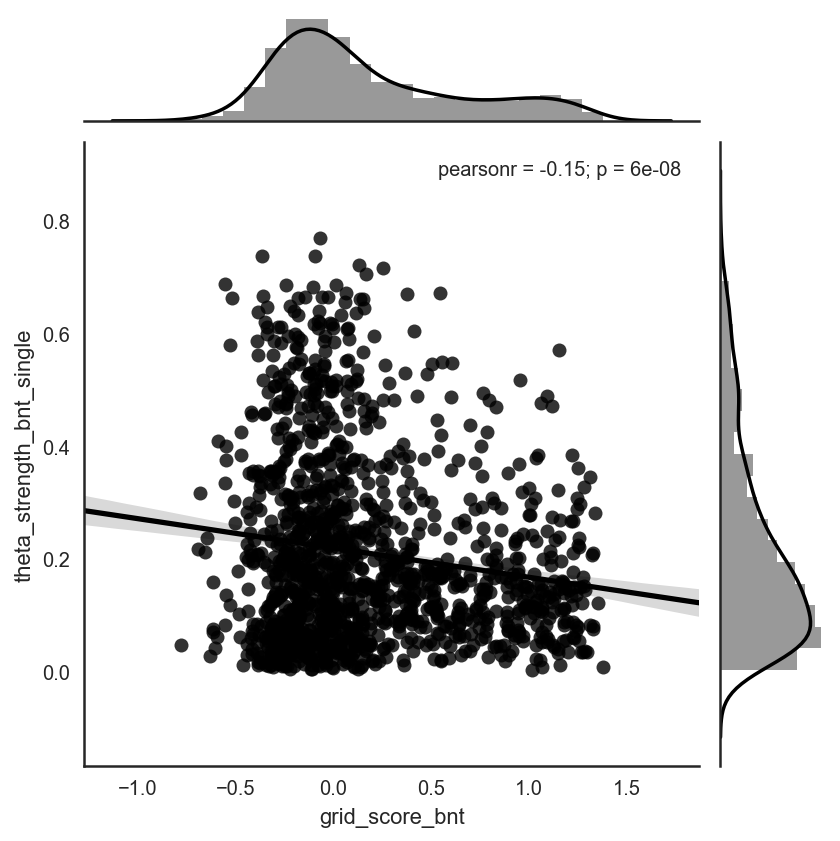

In [57]:
sns.jointplot(x="grid_score_bnt", y="theta_strength_bnt_single", data=dataPile2, kind="reg", color = 'black')
plt.savefig(r'N:\davidcr\stellate paper images\python output\theta vs grid score.svg', format='svg', dpi=1000)


### try a different clustering approach (note the clustering is very slow)
This section uses a very basic clustering approach. The idea is to check whether 1) we can capture a peak- and trough- preferring population and 2) see if a different approach captures grid cells any better. As you can see, the results are quite similar. 

In [58]:

cl= pycircstat.clustering.AggCluster1D(numclust=2)
_, ids = cl.train(dataPile2.theta_mean_phase_bnt_single)
_, testids = cl.test(dataPile2.theta_mean_phase_bnt_single)

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:189: RuntimeWarning: invalid value encountered in multiply
  return np.angle(np.exp(1j * alpha[reshaper_alpha]) /
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in multiply
  np.exp(1j * beta[reshaper_beta]))
C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\pycircstat\descriptive.py:190: RuntimeWarning: invalid value encountered in true_divide
  np.exp(1j * beta[reshaper_beta]))


In [59]:
df5 = dataPile2
df5["testids"] = testids
cl0 = df5[df5.testids ==0]
cl1 = df5[df5.testids ==1]


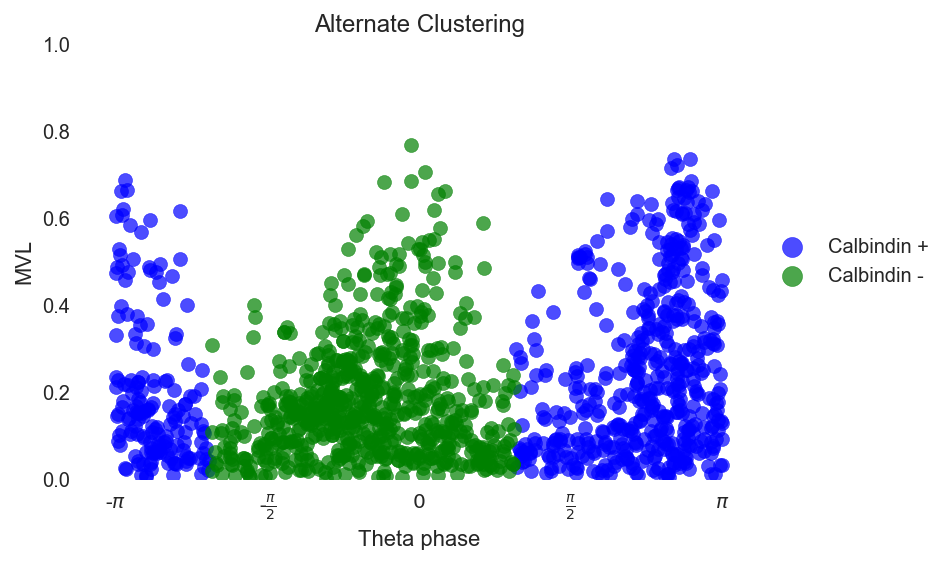

In [60]:
plt.scatter(cl0.theta_mean_phase_bnt_single.values.astype(float),cl0.theta_strength_bnt_single.values.astype(float),c='b',alpha=.7,label='Calbindin +')
plt.scatter(cl1.theta_mean_phase_bnt_single.values.astype(float),cl1.theta_strength_bnt_single.values.astype(float),c='g',alpha=.7,label='Calbindin -')

sns.despine(left=True,bottom=True)
plt.xlabel('Theta phase')
plt.ylabel('MVL')
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
#lgnd.legendHandles[2]._sizes = [100]
plt.ylim([0,1])
plt.xticks([-pi, -pi/2, 0, pi/2, pi],
           [r'-$\pi$',r'-$\frac{\pi}{2}$','$0$', r'$\frac{\pi}{2}$', r'$\pi$' ])
plt.title('Alternate Clustering')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\linear phase vs strength alternate clustering.svg', format='svg', dpi=1000, bbox_inches='tight')
plt.show()

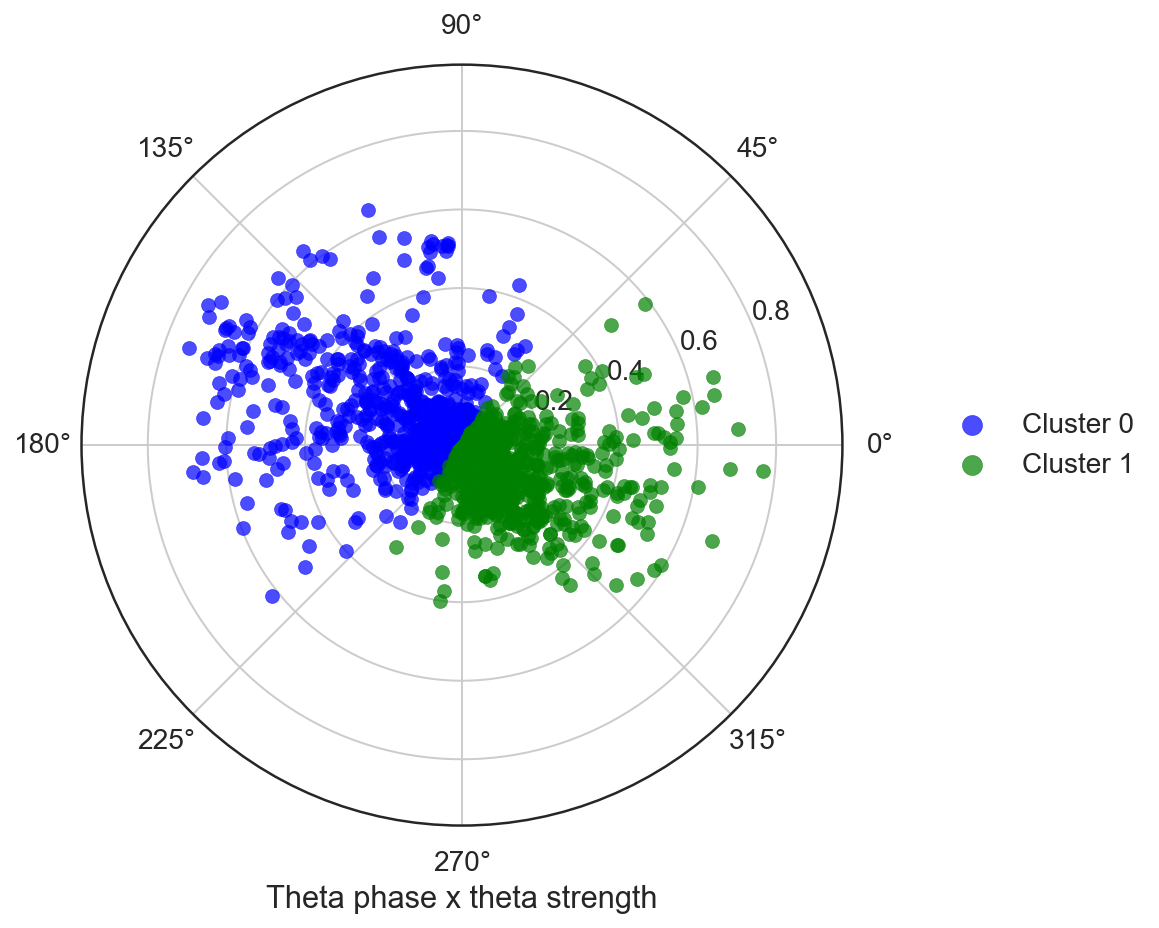

In [61]:
#This will make a plot of the datapoints around a cricle
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(cl0.theta_mean_phase_bnt_single.values.astype(float),cl0.theta_strength_bnt_single.values.astype(float),c='b',alpha=.7,label='Cluster 0')
ax.scatter(cl1.theta_mean_phase_bnt_single.values.astype(float),cl1.theta_strength_bnt_single.values.astype(float),c='g',alpha=.7,label='Cluster 1')
ax.set_xlabel('Theta phase x theta strength')
#plt.title('Classification of Cells (n = 1393)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength alternate clustering.svg', format='eps', dpi=1000, bbox_inches='tight')

plt.show()